In [1]:
%matplotlib inline
from IPython.display import display
from matplotlib import pyplot as plt

import os
import sys
import torch
import random
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import seaborn as sns
from datetime import datetime

#Plotting 
from pandas.plotting import scatter_matrix

#Libraries for Statistical Models
import statsmodels.api as sm

sys.path.append('../')
from MyPyUtil.logconf import logging
from MyPyUtil.util import show_more_rows, seed_everything

#Diable the warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
# logging
log = logging.getLogger(__name__)
log.setLevel(logging.INFO)

seed_everything()

pd.options.display.max_columns = None
pd.options.display.expand_frame_repr = False
pd.options.display.float_format = "{:.3f}".format

# max output width in numpy
np.set_printoptions(
    threshold=sys.maxsize,  # 20,
    edgeitems=10,
    linewidth=140,
    formatter=dict(float=lambda x: "%.3g" % x),
)  # float arrays %.3g

data_dir = f"{os.getcwd()}/../data/"
resources_dir = f"{os.getcwd()}/../resources/"

if os.path.exists(resources_dir) == False:
    os.makedirs(resources_dir, exist_ok=True)

if os.path.exists(data_dir) == False:
    os.makedirs(data_dir, exist_ok=True)

## Load Stock Data


In [3]:
import joblib
from build_stocks_data import tick_data_info

start = datetime(2014, 1, 1)
end = datetime(2023, 12, 31)
empty_vol_threshold = 10

stks_data_file = (
    f"{resources_dir}nasdaq_{start.strftime('%Y%m%d')}-{end.strftime('%Y%m%d')}.pkl"
)

if os.path.exists(stks_data_file):
    stks_data = joblib.load(stks_data_file)
else:
    from build_stocks_data import build_stocks_data

    log.setLevel(logging.ERROR)
    stks_data = build_stocks_data(
        start, end, empty_vol_threshold, data_dir, resources_dir
    )
    joblib.dump(stks_data, stks_data_file)
    log.setLevel(logging.INFO)

display(f"The data has been loaded for a total of {len(stks_data)} stocks.")

'The data has been loaded for a total of 2260 stocks.'

In [4]:
df = stks_data[4].tick_data
with show_more_rows():
    display(df.head(100))

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,19.846,19.894,19.715,19.755,17.297,234684800
2014-01-03,19.745,19.775,19.301,19.321,16.917,392467600
2014-01-06,19.195,19.529,19.057,19.426,17.009,412610800
2014-01-07,19.440,19.499,19.211,19.287,16.887,317209200
2014-01-08,19.243,19.484,19.239,19.409,16.994,258529600
2014-01-09,19.529,19.531,19.120,19.161,16.777,279148800
2014-01-10,19.280,19.314,18.968,19.034,16.665,304976000
2014-01-13,18.925,19.375,18.924,19.133,16.753,378492800
2014-01-14,19.222,19.526,19.202,19.514,17.086,332561600


In [5]:
short_ind = 5
long_ind = 10


def to_adjusted(stk_data):
    """
    Adjusted Open = Open * Adjusted Close / Close
    Adjusted High = High * Adjusted Close / Close
    Adjusted Low = Low * Adjusted Close / Close
    Adjusted volume = Volume / (Adjusted Close / Close)
    """
    ratio_data = stk_data["Adj Close"] / stk_data["Close"]
    adjusted_OHLV = pd.DataFrame(index=stk_data.index)
    adjusted_OHLV["Adj Open"] = ratio_data * stk_data["Open"]
    adjusted_OHLV["Adj High"] = ratio_data * stk_data["High"]
    adjusted_OHLV["Adj Low"] = ratio_data * stk_data["Low"]
    adjusted_OHLV["Adj Close"] = stk_data["Adj Close"]
    adjusted_OHLV["Adj Volume"] = (ratio_data * stk_data["Volume"]).astype("int")
    # adjusted_OHLV["Pre Adj Close"] = stk_data["Adj Close"].shift(1)
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Adj Volume"].shift(1)
    # adjusted_OHLV = adjusted_OHLV.dropna()
    # adjusted_OHLV["Pre Adj Volume"] = adjusted_OHLV["Pre Adj Volume"].astype("int")
    # adjusted_OHLV["B4_Adj Open pct"] = (
    #     adjusted_OHLV["Adj Open"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj High pct"] = (
    #     adjusted_OHLV["Adj High"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Low pct"] = (
    #     adjusted_OHLV["Adj Low"] - adjusted_OHLV["Pre Adj Close"]
    # ) / adjusted_OHLV["Pre Adj Close"]
    # adjusted_OHLV["B4_Adj Volume pct"] = (
    #     adjusted_OHLV["Adj Volume"] - adjusted_OHLV["Pre Adj Volume"]
    # ) / adjusted_OHLV["Pre Adj Volume"]

    return adjusted_OHLV

&#128293; &#9778;
reference:

1. ![candlestick_patterns_8_trigrams](candlestick_patterns_8_trigrams.png)
2. [From Technical Indicators to Machine Learning: A Data-Driven Approach to Price Movement Forecasting](https://medium.com/@nemeth.marcell/from-technical-analysis-to-machine-learning-a-data-driven-approach-to-stock-price-forecasting-pt-1-66a4e3751b00)
3. [Stock Trend Prediction Using Candlestick Charting and Ensemble Machine Learning Techniques With a Novelty Feature Engineering Scheme](Stock_Trend_Prediction_Using_Candlestick_Charting_.pdf)


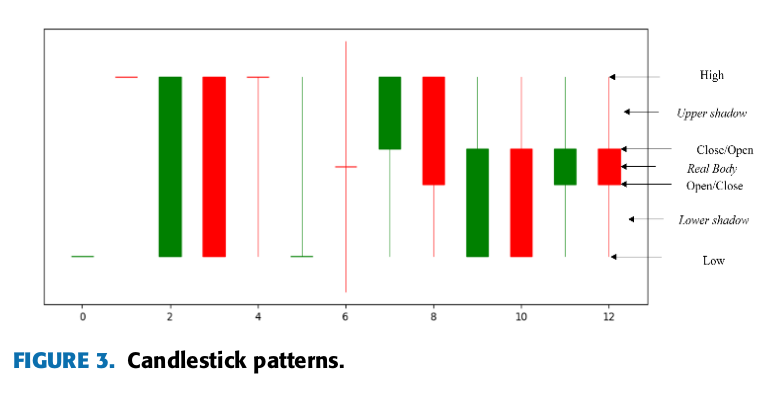
**classes:**  
0.

1.
2. CDLMARUBOZU - -100
3. CDLMARUBOZU - 100
4. CDLDOJI, 100, 收盤價 = 最高價
5. CDLDOJI, -100, 收盤價 = 最低價
6. CDLDOJI, 100, except 4 and 5
7. CDLHAMMER, -100 開盤價 = 最高價
8. CDLHAMMER, 100 收盤價 = 最高價
9. CDLINVERTEDHAMMER, -100 收盤價 = 最低價
10. CDLINVERTEDHAMMER, 100 開盤價 = 最低價
11. CDLSHORTLINE, CDLLONGLINE, -100
12. CDLSHORTLINE, CDLLONGLINE, 100


In [6]:
import pandas_ta

help(pandas_ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

In [27]:
import pandas_ta

# Category
# with show_more_rows():
# display(pandas_ta.Category)
help(pandas_ta.adosc)
# df.ta.adosc()
df.ta.adosc()

Help on function adosc in module pandas_ta.volume.adosc:

adosc(high, low, close, volume, open_=None, fast=None, slow=None, talib=None, offset=None, **kwargs)
    Accumulation/Distribution Oscillator or Chaikin Oscillator
    
    Accumulation/Distribution Oscillator indicator utilizes
    Accumulation/Distribution and treats it similarily to MACD
    or APO.
    
    Sources:
        https://www.investopedia.com/articles/active-trading/031914/understanding-chaikin-oscillator.asp
    
    Calculation:
        Default Inputs:
            fast=12, slow=26
        AD = Accum/Dist
        ad = AD(high, low, close, open)
        fast_ad = EMA(ad, fast)
        slow_ad = EMA(ad, slow)
        ADOSC = fast_ad - slow_ad
    
    Args:
        high (pd.Series): Series of 'high's
        low (pd.Series): Series of 'low's
        close (pd.Series): Series of 'close's
        open (pd.Series): Series of 'open's
        volume (pd.Series): Series of 'volume's
        fast (int): The short period. D

Date
2014-01-02            NaN
2014-01-03            NaN
2014-01-06            NaN
2014-01-07            NaN
2014-01-08            NaN
                 ...     
2023-12-22   17153247.617
2023-12-26    3480637.990
2023-12-27    8427270.205
2023-12-28    4813117.276
2023-12-29   -2538563.086
Name: ADOSC_3_10, Length: 2516, dtype: float64

In [55]:
from indicators import (
    find_swings,
    ema,
    autodetect_divergence,
    classify_swings,
    detect_divergence,
)

if "autoplot" in sys.modules:
    print("delete autoplot module")
    del sys.modules["autoplot"]
from autoplot import AutoPlot

adosc = df.ta.adosc()
# adosc_divergence = autodetect_divergence(df, adosc)
# Price swings
price_swings = find_swings(df)
price_swings_classified = classify_swings(price_swings)

# Indicator swings
indicator_swings = find_swings(adosc)
indicator_classified = classify_swings(indicator_swings)

# Detect divergence
adosc_divergence = detect_divergence(
    price_swings_classified, indicator_classified, tol=2, method=0
)

# with show_more_rows():
#     display(price_swings.head(100))
#     display(price_swings_classified.head(100))
#     display(indicator_swings.head(100))
#     display(indicator_classified.head(100))
#     display(adosc_divergence.head(100))

# display(adosc_divergence)

hl2 = (df["High"].values + df["Low"].values) / 2
ema2 = pd.Series(ema(hl2, 2), index=df.index)

# # Construct indicators dictionary
indicators = {
    "ADOSC (14)": {"type": "below", "data": adosc},
    "Bullish divergence": {"type": "below", "data": adosc_divergence["regularBull"]},
    # "MACD (12/26/9)": {
    #     "type": "MACD",
    #     "macd": MACD_df.MACD_12_26_9,
    #     "signal": MACD_df.MACDs_12_26_9,
    #     # "crossvals": MACD_CO_vals,
    # },
    "EMA (2)": {"type": "MA", "data": ema2},
    # "EMA (50)": {"type": "MA", "data": ema50},
    # "EMA (200)": {"type": "MA", "data": ema200},
    "Swing Detection": {"type": "Swings", "data": price_swings},
    # "MACD Crossovers": {"type": "below", "data": MACD_CO},
    # "Bullish divergence": {"type": "below", "data": rsi_divergence["regularBull"]},
}

# Instantiate AutoPlot and plot
ap = AutoPlot(df)
ap.configure(jupyter_notebook=True)
ap.plot(indicators=indicators)  # , instrument=instrument)


# swings_data = find_swings(df)
# # display(swings_data)

# MACD_df = df.ta.macd()
# rsi = df.ta.rsi()
# display(rsi)

# rsi_divergence = autodetect_divergence(df, rsi)
# display(rsi_divergence)
# ema50 = df.ta.ema(50)
# ema200 = df.ta.ema(200)
# # Construct indicators dictionary
# indicators = {
#     "RSI (14)": {"type": "RSI", "data": rsi},
#     # "MACD (12/26/9)": {
#     #     "type": "MACD",
#     #     "macd": MACD_df.MACD_12_26_9,
#     #     "signal": MACD_df.MACDs_12_26_9,
#     #     # "crossvals": MACD_CO_vals,
#     # },
#     "EMA (2)": {"type": "MA", "data": ema2},
#     "EMA (50)": {"type": "MA", "data": ema50},
#     # "EMA (200)": {"type": "MA", "data": ema200},
#     # "Swing Detection": {"type": "Swings", "data": swings_data},
#     # "MACD Crossovers": {"type": "below", "data": MACD_CO},
#     "Bullish divergence": {"type": "below", "data": rsi_divergence["regularBull"]},
# }

# # Instantiate AutoPlot and plot
# ap = AutoPlot(df)
# ap.plot(indicators=indicators)  # , instrument=instrument)

delete autoplot module


Loading BokehJS ...

In [ ]:
close = "Close"
high = "High"
low = "Low"
volume = "Volume"
prefix = ""
suffix = ""

data = pd.DataFrame(index=df.index)
data["close"] = df[close]
data["sma20"] = df.ta.sma(close=close, length=20)
data["sma65"] = df.ta.sma(close=close, length=65)
data["ad"] = df.ta.ad(high=high, low=low, close=close, volume=volume)
data["obv"] = df.ta.obv(close=close, volume=volume)

data["ad20"] = data.ta.sma(close="ad", length=20)
data["ad65"] = data.ta.sma(close="ad", length=65)
data["obv20"] = data.ta.sma(close="obv", length=20)
data["obv65"] = data.ta.sma(close="obv", length=65)


data["OBV_ADL_BULL_DIVERGENCE"] = 0
data["OBV_ADL_BEAR_DIVERGENCE"] = 0

"""
[Daily Close < Daily SMA(65,Daily Close)] 
AND [Daily AccDist > Daily AccDist Signal (65)] 
AND [Daily OBV > Daily OBV Signal(65)] 
AND [Daily Close < Daily SMA(20,Daily Close)] 
AND [Daily AccDist > Daily AccDist Signal (20)] 
AND [Daily OBV > Daily OBV Signal(20)]
"""
data.loc[
    (data["close"] < data["sma65"])
    & (data["ad"] > data["ad65"])
    & (data["obv"] > data["obv65"])
    & (data["close"] < data["sma20"])
    & (data["ad"] > data["ad20"])
    & (data["obv"] > data["obv20"]),
    "OBV_ADL_BULL_DIVERGENCE",
] = 1

"""
[Daily Close > Daily SMA(65,Daily Close)] 
AND [Daily AccDist < Daily AccDist Signal (65)] 
AND [Daily OBV < Daily OBV Signal(65)] 
AND [Daily Close > Daily SMA(20,Daily Close)] 
AND [Daily AccDist < Daily AccDist Signal (20)] 
AND [Daily OBV < Daily OBV Signal(20)]
"""
data.loc[
    (data["close"] > data["sma65"])
    & (data["ad"] < data["ad65"])
    & (data["obv"] < data["obv65"])
    & (data["close"] > data["sma20"])
    & (data["ad"] < data["ad20"])
    & (data["obv"] < data["obv20"]),
    "OBV_ADL_BEAR_DIVERGENCE",
] = 1

data = data.dropna()

buy_sell_signals = pd.DataFrame(index=df.index)
buy_sell_signals[f"{prefix}OBV_ADL_BULL_DIVERGENCE{suffix}"] = data[
    "OBV_ADL_BULL_DIVERGENCE"
]
buy_sell_signals[f"{prefix}OBV_ADL_BEAR_DIVERGENCE{suffix}"] = data[
    "OBV_ADL_BEAR_DIVERGENCE"
]

with show_more_rows():
    display(data.head(100))
    display(buy_sell_signals.head(100))
    display(
        buy_sell_signals[
            (buy_sell_signals.OBV_ADL_BULL_DIVERGENCE > 0)
            | (buy_sell_signals.OBV_ADL_BEAR_DIVERGENCE)
        ]
    )

,close,sma20,sma65,ad,obv,ad20,ad65,obv20,obv65,OBV_ADL_BULL_DIVERGENCE,OBV_ADL_BEAR_DIVERGENCE
Date,,,,,,,,,,,
2014-04-04,18.994,19.107,19.035,-488941773.579,654214400.000,-428976805.293,-498349454.266,938943460.000,613094160.000,0,0
2014-04-07,18.695,19.093,19.019,-677138022.815,364364000.000,-438602543.592,-506756285.520,925662920.000,615089224.615,0,0
2014-04-08,18.694,19.071,19.009,-609427425.543,120475600.000,-446772367.311,-508583985.307,886226740.000,619370123.077,0,0
2014-04-09,18.940,19.060,19.002,-411533364.636,326645200.000,-452256793.731,-510954685.789,847132720.000,620475003.077,0,0
2014-04-10,18.696,19.047,18.992,-634802352.483,86993200.000,-459675073.550,-514453762.765,808943240.000,622773070.769,0,0
2014-04-11,18.558,19.038,18.979,-670616345.489,-184724400.000,-462104857.272,-520049639.499,769027840.000,616913489.231,0,0
2014-04-14,18.631,19.029,18.971,-504827381.805,20949600.000,-450578555.042,-519673427.045,729418900.000,618512720.000,0,0
2014-04-15,18.499,19.005,18.963,-428575765.021,-245540400.000,-443956903.928,-515204364.338,666003100.000,620704043.077,0,0
2014-04-16,18.536,18.983,18.954,-342359925.629,-30774800.000,-428802597.294,-508984423.708,624563380.000,620376486.154,0,0


,OBV_ADL_BULL_DIVERGENCE,OBV_ADL_BEAR_DIVERGENCE
Date,,
2014-01-02,NaN,NaN
2014-01-03,NaN,NaN
2014-01-06,NaN,NaN
2014-01-07,NaN,NaN
2014-01-08,NaN,NaN
2014-01-09,NaN,NaN
2014-01-10,NaN,NaN
2014-01-13,NaN,NaN
2014-01-14,NaN,NaN


,OBV_ADL_BULL_DIVERGENCE,OBV_ADL_BEAR_DIVERGENCE
Date,,
2014-10-20,0.000,1.000
2014-12-30,0.000,1.000
2015-01-08,0.000,1.000
2015-05-04,0.000,1.000
2015-05-08,0.000,1.000
2015-05-14,0.000,1.000
2015-05-15,0.000,1.000
2015-05-19,0.000,1.000
2015-05-20,0.000,1.000


In [ ]:
if "candle_signal" in sys.modules:
    print("delete candle_signal module")
    del sys.modules["candle_signal"]
from candle_signal import create_candle_signals

if "eight_trigrams" in sys.modules:
    print("delete eight_trigrams module")
    del sys.modules["eight_trigrams"]
from eight_trigrams import create_trigrams

if "awesome_oscillator" in sys.modules:
    print("delete awesome_oscillator module")
    del sys.modules["awesome_oscillator"]
from strategies.awesome_oscillator import detect_awesome_saucers

if "strategies" in sys.modules:
    print("delete strategies")
    del sys.modules["strategies"]
from strategies import (
    macd_strategy,
    cti_strategy,
    er_strategy,
    eri_strategy,
    AD_OBV_strategy,
)

# if "cti_strategy" in sys.modules:
#     print("delete cti_strategy")
# from strategies.cti_strategy import cti_strategy

# if "er_strategy" in sys.modules:
#     print("delete er_strategy")
#     del sys.modules["er_strategy"]
# from strategies.er_strategy import er_strategy

# if "eri_strategy" in sys.modules:
#     print("delete eri_strategy")
#     del sys.modules["eri_strategy"]
# from strategies.eri_strategy import eri_strategy

# if "AD_OBV_strategy" in sys.modules:
#     print("delete AD_OBV_strategy")
#     del sys.modules["AD_OBV_strategy"]
# from strategies.AD_OBV_strategy import AD_OBV_strategy

import pandas_ta as ta


stk_data = stks_data[4].tick_data
short_ind = 5
long_ind = 10

adjusted_OHLV = to_adjusted(stk_data)

data = pd.concat(
    [
        AD_OBV_strategy.create_signals(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            volume="Adj Volume",
            prefix="c",
            suffix="m",
        ),
        eri_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            length=13,
            prefix="c",
            suffix="m",
        ),
        er_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.er(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        cti_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=5,
            slow=10,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=5,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cti(
            close="Adj Close",
            length=10,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cfo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stochrsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.cmo(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rsi(
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.stoch(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.rvi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="v",
        ),
        adjusted_OHLV.ta.mfi(
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            volume="Adj Volume",
            prefix="f",
            suffix="m",
        ),
        macd_strategy.create_buy_sell_signals(
            adjusted_OHLV,
            close="Adj Close",
            fast=12,
            slow=26,
            signal=9,
            prefix="c",
            suffix="m",
        ),
        adjusted_OHLV.ta.brar(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            scalar=1,
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bop(
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="f",
            suffix="m",
        ),
        adjusted_OHLV.ta.bias(close="Adj Close", prefix="f", suffix="m"),
        detect_awesome_saucers(
            adjusted_OHLV, high="Adj High", low="Adj Low", prefix="c", suffix="m"
        ),
        create_trigrams(
            adjusted_OHLV,
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="t",
        ),
        create_candle_signals(
            adjusted_OHLV,
            open="Adj Open",
            high="Adj High",
            low="Adj Low",
            close="Adj Close",
            prefix="c",
            suffix="c",
        ),
    ],
    axis=1,
)

with show_more_rows():
    display(data.head(100))

data = data.dropna()
display(data)

"""
# OVERLAP INDICATORS
data = pd.DataFrame()
# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)
# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)
# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)
# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)
# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)
# data["sar"] = tb.SAR(df["High"], df["Low"])

# MOMENTUM INDICATORS
data["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)
data["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])
data["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(
    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9
)
data["mfi"] = tb.MFI(
    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind
)
data["mom"] = tb.MOM(df["Close"], timeperiod=long_ind)
data["rsi"] = tb.RSI(df["Close"], timeperiod=long_ind)

# # VOLUME INDICATORS
# data["ad"] = tb.AD(df["High"], df["Low"], df["Close"], df["Volume"])
# data["adosc"] = tb.ADOSC(
#     df["High"],
#     df["Low"],
#     df["Close"],
#     df["Volume"],
#     fastperiod=short_ind,
#     slowperiod=long_ind,
# )
# data["obv"] = tb.OBV(df["Close"], df["Volume"])
data["trange"] = tb.TRANGE(df["High"], df["Low"], df["Close"])
data["atr"] = tb.ATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)
data["natr"] = tb.NATR(df["High"], df["Low"], df["Close"], timeperiod=long_ind)

# data.reset_index(drop=True, inplace=True)
display(data)
display(create_trigrams(df))
# TARGET
# data["target"] = df["Close"].pct_change().rolling(avg_days).mean().shift(avg_days)

# data.dropna(inplace=True)

# columns = ["Open", "High", "Volume", "Low", "trigrams", "target"]

# if custom == True:
#     df = create_signals(data=df)
#     columns = columns + [
#         "shortLineCdl",
#         "longLineCdl",
#         "spinningTop",
#         "closingMarubozu",
#     ]

# if "O" in additional:
#     columns = columns + ["ma", "ema", "dema", "kama", "sma", "sar"]
# if "M" in additional:
#     columns = columns + ["adx", "cci", "apo", "bop", "macd", "mfi", "mom", "rsi"]
# if "V" in additional:
#     columns = columns + ["ad", "adosc", "obv", "trange", "atr", "natr"]

# df = df[columns]
"""

delete strategies
[X] Ooops!!! It's True, the series 'high' was not found in Adj Open, Adj High, Adj Low, Adj Close, Adj Volume
[X] Ooops!!! It's True, the series 'low' was not found in Adj Open, Adj High, Adj Low, Adj Close, Adj Volume


,c_OBV_ADL_BULL_DIVERGENCE_m,c_OBV_ADL_BEAR_DIVERGENCE_m,c_ERI_BULL_m,c_ERI_BEAR_m,c_ER_BULL_m,c_ER_BEAR_m,f_ER_10_m,c_CTI_BULL_m,c_CTI_BEAR_m,f_CTI_5_m,f_CTI_10_m,f_CFO_9_m,f_STOCHRSIk_14_14_3_3_m,f_STOCHRSId_14_14_3_3_m,f_CMO_14_m,f_RSI_14_m,f_STOCHk_14_3_3_m,f_STOCHd_14_3_3_m,f_RVI_14_v,f_MFI_14_m,c_CORSSOVER_BULL_m,c_CORSSOVER_BEAR_m,c_ZERO_CORSSING_BULL_m,c_ZERO_CORSSING_BEAR_m,f_AR_26_m,f_BR_26_m,f_BOP_m,f_BIAS_SMA_26_m,c_SAUCERS_BULL_m,c_SAUCERS_BEAR_m,c_BullishHarami_t,c_BullishHorn_t,c_BullishHigh_t,c_BullishLow_t,c_BearHarami_t,c_BearHorn_t,c_BearHigh_t,c_BearLow_t,c_CDL3LINESTRIKE_BULL_c,c_CDL3LINESTRIKE_BEAR_c,c_CDL3BLACKCROWS_BULL_c,c_CDL3BLACKCROWS_BEAR_c,c_CDLEVENINGSTAR_BULL_c,c_CDLEVENINGSTAR_BEAR_c,c_CDLTASUKIGAP_BULL_c,c_CDLTASUKIGAP_BEAR_c,c_CDLINVERTEDHAMMER_BULL_c,c_CDLINVERTEDHAMMER_BEAR_c,c_CDLMATCHINGLOW_BULL_c,c_CDLMATCHINGLOW_BEAR_c,c_CDLABANDONEDBABY_BULL_c,c_CDLABANDONEDBABY_BEAR_c,c_CDLBREAKAWAY_BULL_c,c_CDLBREAKAWAY_BEAR_c,c_CDLMORNINGSTAR_BULL_c,c_CDLMORNINGSTAR_BEAR_c,c_CDLPIERCING_BULL_c,c_CDLPIERCING_BEAR_c,c_CDLSTICKSANDWICH_BULL_c,c_CDLSTICKSANDWICH_BEAR_c,c_CDLTHRUSTING_BULL_c,c_CDLTHRUSTING_BEAR_c,c_CDLCOUNTERATTACK_BEAR_c,c_CDLCOUNTERATTACK_BULL_c,c_CDLINNECK_BULL_c,c_CDLINNECK_BEAR_c,c_CDL3INSIDE_BULL_c,c_CDL3INSIDE_BEAR_c,c_CDLHOMINGPIGEON_BULL_c,c_CDLHOMINGPIGEON_BEAR_c,c_CDLDARKCLOUDCOVER_BULL_c,c_CDLDARKCLOUDCOVER_BEAR_c,c_CDLIDENTICAL3CROWS_BULL_c,c_CDLIDENTICAL3CROWS_BEAR_c,c_CDLMORNINGDOJISTAR_BULL_c,c_CDLMORNINGDOJISTAR_BEAR_c,c_CDLXSIDEGAP3METHODS_BULL_c,c_CDLXSIDEGAP3METHODS_BEAR_c,c_CDLTRISTAR_BULL_c,c_CDLTRISTAR_BEAR_c,c_CDLGAPSIDESIDEWHITE_BULL_c,c_CDLGAPSIDESIDEWHITE_BEAR_c,c_CDLEVENINGDOJISTAR_BULL_c,c_CDLEVENINGDOJISTAR_BEAR_c,c_CDL3WHITESOLDIERS_BULL_c,c_CDL3WHITESOLDIERS_BEAR_c,c_CDLONNECK_BULL_c,c_CDLONNECK_BEAR_c,c_CDL3OUTSIDE_BULL_c,c_CDL3OUTSIDE_BEAR_c,c_CDLRICKSHAWMAN_BULL_c,c_CDLRICKSHAWMAN_BEAR_c,c_CDLSEPARATINGLINES_BULL_c,c_CDLSEPARATINGLINES_BEAR_c,c_CDLLONGLEGGEDDOJI_BULL_c,c_CDLLONGLEGGEDDOJI_BEAR_c,c_CDLHARAMI_BULL_c,c_CDLHARAMI_BEAR_c,c_CDLLADDERBOTTOM_BULL_c,c_CDLLADDERBOTTOM_BEAR_c,c_CDLCLOSINGMARUBOZU_BULL_c,c_CDLCLOSINGMARUBOZU_BEAR_c,c_CDLTAKURI_BULL_c,c_CDLTAKURI_BEAR_c,c_CDLDOJISTAR_BULL_c,c_CDLDOJISTAR_BEAR_c,c_CDLHARAMICROSS_BULL_c,c_CDLHARAMICROSS_BEAR_c,c_CDLADVANCEBLOCK_BULL_c,c_CDLADVANCEBLOCK_BEAR_c,c_CDLSHOOTINGSTAR_BULL_c,c_CDLSHOOTINGSTAR_BEAR_c,c_CDLMARUBOZU_BULL_c,c_CDLMARUBOZU_BEAR_c,c_CDLUNIQUE3RIVER_BULL_c,c_CDLUNIQUE3RIVER_BEAR_c,c_CDL2CROWS_BULL_c,c_CDL2CROWS_BEAR_c,c_CDLBELTHOLD_BULL_c,c_CDLBELTHOLD_BEAR_c,c_CDLHAMMER_BULL_c,c_CDLHAMMER_BEAR_c,c_CDLSHORTLINE_BULL_c,c_CDLSHORTLINE_BEAR_c,c_CDLHIGHWAVE_BULL_c,c_CDLHIGHWAVE_BEAR_c,c_CDLLONGLINE_BULL_c,c_CDLLONGLINE_BEAR_c,c_CDLSPINNINGTOP_BULL_c,c_CDLSPINNINGTOP_BEAR_c,c_CDLUPSIDEGAP2CROWS_BULL_c,c_CDLUPSIDEGAP2CROWS_BEAR_c,c_CDLGRAVESTONEDOJI_BULL_c,c_CDLGRAVESTONEDOJI_BEAR_c,c_CDLHIKKAKEMOD_BULL_c,c_CDLHIKKAKEMOD_BEAR_c,c_CDLHIKKAKE_BULL_c,c_CDLHIKKAKE_BEAR_c,c_CDLENGULFING_BULL_c,c_CDLENGULFING_BEAR_c,c_CDLMATHOLD_BULL_c,c_CDLMATHOLD_BEAR_c,c_CDLHANGINGMAN_BULL_c,c_CDLHANGINGMAN_BEAR_c,c_CDLSTALLEDPATTERN_BULL_c,c_CDLSTALLEDPATTERN_BEAR_c,c_CDLRISEFALL3METHODS_BULL_c,c_CDLRISEFALL3METHODS_BEAR_c,c_CDLKICKING_BULL_c,c_CDLKICKING_BEAR_c,c_CDLDRAGONFLYDOJI_BULL_c,c_CDLDRAGONFLYDOJI_BEAR_c,c_CDLCONCEALBABYSWALL_BULL_c,c_CDLCONCEALBABYSWALL_BEAR_c,c_CDLKICKINGBYLENGTH_BEAR_c,c_CDLKICKINGBYLENGTH_BULL_c,c_CDL3STARSINSOUTH_BULL_c,c_CDL3STARSINSOUTH_BEAR_c,c_CDLDOJI_BULL_c,c_CDLDOJI_BEAR_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

,c_OBV_ADL_BULL_DIVERGENCE_m,c_OBV_ADL_BEAR_DIVERGENCE_m,c_ERI_BULL_m,c_ERI_BEAR_m,c_ER_BULL_m,c_ER_BEAR_m,f_ER_10_m,c_CTI_BULL_m,c_CTI_BEAR_m,f_CTI_5_m,f_CTI_10_m,f_CFO_9_m,f_STOCHRSIk_14_14_3_3_m,f_STOCHRSId_14_14_3_3_m,f_CMO_14_m,f_RSI_14_m,f_STOCHk_14_3_3_m,f_STOCHd_14_3_3_m,f_RVI_14_v,f_MFI_14_m,c_CORSSOVER_BULL_m,c_CORSSOVER_BEAR_m,c_ZERO_CORSSING_BULL_m,c_ZERO_CORSSING_BEAR_m,f_AR_26_m,f_BR_26_m,f_BOP_m,f_BIAS_SMA_26_m,c_SAUCERS_BULL_m,c_SAUCERS_BEAR_m,c_BullishHarami_t,c_BullishHorn_t,c_BullishHigh_t,c_BullishLow_t,c_BearHarami_t,c_BearHorn_t,c_BearHigh_t,c_BearLow_t,c_CDL3LINESTRIKE_BULL_c,c_CDL3LINESTRIKE_BEAR_c,c_CDL3BLACKCROWS_BULL_c,c_CDL3BLACKCROWS_BEAR_c,c_CDLEVENINGSTAR_BULL_c,c_CDLEVENINGSTAR_BEAR_c,c_CDLTASUKIGAP_BULL_c,c_CDLTASUKIGAP_BEAR_c,c_CDLINVERTEDHAMMER_BULL_c,c_CDLINVERTEDHAMMER_BEAR_c,c_CDLMATCHINGLOW_BULL_c,c_CDLMATCHINGLOW_BEAR_c,c_CDLABANDONEDBABY_BULL_c,c_CDLABANDONEDBABY_BEAR_c,c_CDLBREAKAWAY_BULL_c,c_CDLBREAKAWAY_BEAR_c,c_CDLMORNINGSTAR_BULL_c,c_CDLMORNINGSTAR_BEAR_c,c_CDLPIERCING_BULL_c,c_CDLPIERCING_BEAR_c,c_CDLSTICKSANDWICH_BULL_c,c_CDLSTICKSANDWICH_BEAR_c,c_CDLTHRUSTING_BULL_c,c_CDLTHRUSTING_BEAR_c,c_CDLCOUNTERATTACK_BEAR_c,c_CDLCOUNTERATTACK_BULL_c,c_CDLINNECK_BULL_c,c_CDLINNECK_BEAR_c,c_CDL3INSIDE_BULL_c,c_CDL3INSIDE_BEAR_c,c_CDLHOMINGPIGEON_BULL_c,c_CDLHOMINGPIGEON_BEAR_c,c_CDLDARKCLOUDCOVER_BULL_c,c_CDLDARKCLOUDCOVER_BEAR_c,c_CDLIDENTICAL3CROWS_BULL_c,c_CDLIDENTICAL3CROWS_BEAR_c,c_CDLMORNINGDOJISTAR_BULL_c,c_CDLMORNINGDOJISTAR_BEAR_c,c_CDLXSIDEGAP3METHODS_BULL_c,c_CDLXSIDEGAP3METHODS_BEAR_c,c_CDLTRISTAR_BULL_c,c_CDLTRISTAR_BEAR_c,c_CDLGAPSIDESIDEWHITE_BULL_c,c_CDLGAPSIDESIDEWHITE_BEAR_c,c_CDLEVENINGDOJISTAR_BULL_c,c_CDLEVENINGDOJISTAR_BEAR_c,c_CDL3WHITESOLDIERS_BULL_c,c_CDL3WHITESOLDIERS_BEAR_c,c_CDLONNECK_BULL_c,c_CDLONNECK_BEAR_c,c_CDL3OUTSIDE_BULL_c,c_CDL3OUTSIDE_BEAR_c,c_CDLRICKSHAWMAN_BULL_c,c_CDLRICKSHAWMAN_BEAR_c,c_CDLSEPARATINGLINES_BULL_c,c_CDLSEPARATINGLINES_BEAR_c,c_CDLLONGLEGGEDDOJI_BULL_c,c_CDLLONGLEGGEDDOJI_BEAR_c,c_CDLHARAMI_BULL_c,c_CDLHARAMI_BEAR_c,c_CDLLADDERBOTTOM_BULL_c,c_CDLLADDERBOTTOM_BEAR_c,c_CDLCLOSINGMARUBOZU_BULL_c,c_CDLCLOSINGMARUBOZU_BEAR_c,c_CDLTAKURI_BULL_c,c_CDLTAKURI_BEAR_c,c_CDLDOJISTAR_BULL_c,c_CDLDOJISTAR_BEAR_c,c_CDLHARAMICROSS_BULL_c,c_CDLHARAMICROSS_BEAR_c,c_CDLADVANCEBLOCK_BULL_c,c_CDLADVANCEBLOCK_BEAR_c,c_CDLSHOOTINGSTAR_BULL_c,c_CDLSHOOTINGSTAR_BEAR_c,c_CDLMARUBOZU_BULL_c,c_CDLMARUBOZU_BEAR_c,c_CDLUNIQUE3RIVER_BULL_c,c_CDLUNIQUE3RIVER_BEAR_c,c_CDL2CROWS_BULL_c,c_CDL2CROWS_BEAR_c,c_CDLBELTHOLD_BULL_c,c_CDLBELTHOLD_BEAR_c,c_CDLHAMMER_BULL_c,c_CDLHAMMER_BEAR_c,c_CDLSHORTLINE_BULL_c,c_CDLSHORTLINE_BEAR_c,c_CDLHIGHWAVE_BULL_c,c_CDLHIGHWAVE_BEAR_c,c_CDLLONGLINE_BULL_c,c_CDLLONGLINE_BEAR_c,c_CDLSPINNINGTOP_BULL_c,c_CDLSPINNINGTOP_BEAR_c,c_CDLUPSIDEGAP2CROWS_BULL_c,c_CDLUPSIDEGAP2CROWS_BEAR_c,c_CDLGRAVESTONEDOJI_BULL_c,c_CDLGRAVESTONEDOJI_BEAR_c,c_CDLHIKKAKEMOD_BULL_c,c_CDLHIKKAKEMOD_BEAR_c,c_CDLHIKKAKE_BULL_c,c_CDLHIKKAKE_BEAR_c,c_CDLENGULFING_BULL_c,c_CDLENGULFING_BEAR_c,c_CDLMATHOLD_BULL_c,c_CDLMATHOLD_BEAR_c,c_CDLHANGINGMAN_BULL_c,c_CDLHANGINGMAN_BEAR_c,c_CDLSTALLEDPATTERN_BULL_c,c_CDLSTALLEDPATTERN_BEAR_c,c_CDLRISEFALL3METHODS_BULL_c,c_CDLRISEFALL3METHODS_BEAR_c,c_CDLKICKING_BULL_c,c_CDLKICKING_BEAR_c,c_CDLDRAGONFLYDOJI_BULL_c,c_CDLDRAGONFLYDOJI_BEAR_c,c_CDLCONCEALBABYSWALL_BULL_c,c_CDLCONCEALBABYSWALL_BEAR_c,c_CDLKICKINGBYLENGTH_BEAR_c,c_CDLKICKINGBYLENGTH_BULL_c,c_CDL3STARSINSOUTH_BULL_c,c_CDL3STARSINSOUTH_BEAR_c,c_CDLDOJI_BULL_c,c_CDLDOJI_BEAR_c
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-04-04,0.000,0.000,0.000,0.000,0.000,0.000,0.028,0.000,0.000,-0.467,-0.420,-0.833,43.140,60.288,-6.041,46.979,53.369,62.656,40.094,59.312,0.000,0.000,0.000,0.000,0.724,1.133,-0.848,-0.004,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

'\n# OVERLAP INDICATORS\ndata = pd.DataFrame()\n# data["ma"] = tb.MA(df["Close"], timeperiod=short_ind)\n# data["ema"] = tb.EMA(df["Close"], timeperiod=long_ind)\n# data["dema"] = tb.DEMA(df["Close"], timeperiod=short_ind)\n# data["kama"] = tb.KAMA(df["Close"], timeperiod=short_ind)\n# data["sma"] = tb.SMA(df["Close"], timeperiod=long_ind)\n# data["sar"] = tb.SAR(df["High"], df["Low"])\n\n# MOMENTUM INDICATORS\ndata["adx"] = tb.ADX(df["High"], df["Low"], df["Close"], timeperiod=long_ind)\ndata["cci"] = tb.CCI(df["High"], df["Low"], df["Close"], timeperiod=long_ind)\ndata["apo"] = tb.APO(df["Close"], fastperiod=long_ind, slowperiod=short_ind)\ndata["bop"] = tb.BOP(df["Open"], df["High"], df["Low"], df["Close"])\ndata["macd"], data["macdsignal"], data["macdhist"] = tb.MACD(\n    df["Close"], fastperiod=12, slowperiod=26, signalperiod=9\n)\ndata["mfi"] = tb.MFI(\n    df["High"], df["Low"], df["Close"], df["Volume"], timeperiod=long_ind\n)\ndata["mom"] = tb.MOM(df["Close"], timeperiod=long